In [1]:
import keras
import numpy as np
import os
import PIL
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from pylab import imread, imshow
from skimage.color import rgb2gray
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, core , UpSampling2D
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        # second layer
        x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
        padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    return x

In [22]:
def get_unet(dropout, input_img):
    inputs = input_img
    patch_size = 32
    print("PATCH SIZE", patch_size)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(inputs)
    conv1 = Dropout(dropout)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    #
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(pool1)
    conv2 = Dropout(dropout)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    #
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_last')(pool2)
    conv3 = Dropout(dropout)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv3)

    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = concatenate([conv2,up1])
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(up1)
    conv4 = Dropout(dropout)(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv4)
    #
    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = concatenate([conv1,up2])
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(up2)
    conv5 = Dropout(dropout)(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_last')(conv5)
    #
    conv6 = Conv2D(2, (1, 1), activation='relu',padding='same',data_format='channels_last')(conv5)
    conv6 = core.Reshape((2,32*32))(conv6)
    conv6 = core.Permute((2,1))(conv6)
    ############
    conv7 = core.Activation('softmax')(conv6)

    model = Model(inputs=inputs, outputs=conv7)
    opt  = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer = opt, loss = 'binary_crossentropy')
    return model

In [23]:
def get_unet_seismic(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout)(p1)
    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)
    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)
    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    opt  = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer = opt, loss = 'binary_crossentropy')
    return model

In [5]:
def load_images_from_folder(folder_path):
    file_names = os.listdir(folder_path)
    file_names.sort()
    images = []
    for filename in file_names:
        try:
            image =imread(folder_path + filename)
            images.append(rgb2gray(image).reshape(32,32,1))
        except:
            continue
    return images

In [6]:
def generator(x_train, y_train, batch_size):
    data_gen = ImageDataGenerator(
        horizontal_flip = True, vertical_flip = True,
    ).flow(x_train, x_train, batch_size, seed=1)
    mask_gen = ImageDataGenerator(
        horizontal_flip = True, vertical_flip = True
    ).flow(y_train, y_train, batch_size, seed=1)
    while True:
        x_batch, _ = data_gen.next()
        y_batch, _ = mask_gen.next()
        yield x_batch, y_batch

## Test data augmentation function

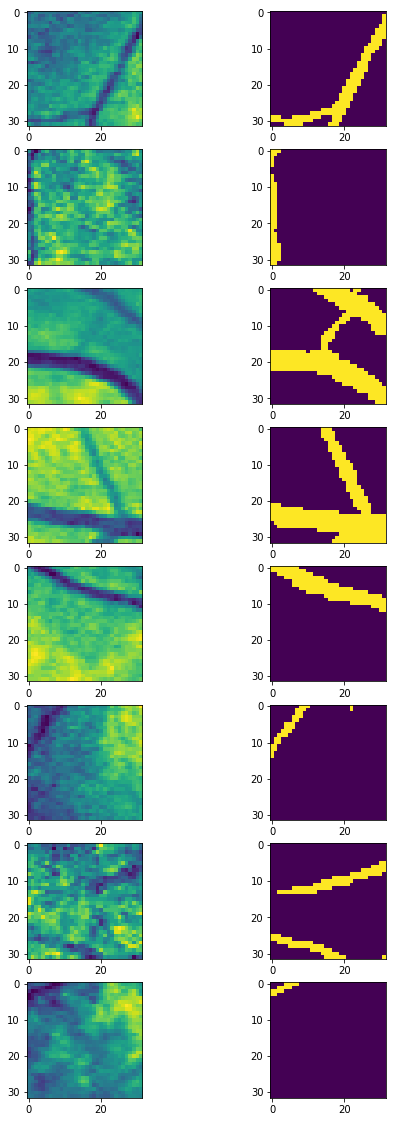

In [7]:

X_train = np.array(load_images_from_folder("../../data/DRIVE/training/patches/"))
y_train = np.array(load_images_from_folder("../../data/DRIVE/training/patchLabels/"))
image_batch, mask_batch = next(generator(X_train, y_train, 8))
fix, ax = plt.subplots(8,2, figsize=(8,20))
for i in range(8):
    ax[i,0].imshow(image_batch[i,:,:,0])
    ax[i,1].imshow(mask_batch[i,:,:,0])
plt.show()

In [27]:
def train(epochs, n_folds, model_dict):
    X = np.array(load_images_from_folder("../../data/DRIVE/training/patches/"))
    y = np.array(load_images_from_folder("../../data/DRIVE/training/patchLabels/"))
    load_model = model_dict['load_model']
    args = model_dict['args']
    model = load_model(**args)
    
    batch_size = 32
    historyList =[]
    if n_folds > 0:
        if (len(X) % n_folds) != 0:
            raise Exception('Same eye in validation and traning set, Patches: ', X_train.shape[1], ' Folds', n_folds)
        sizeFold = len(X) // n_folds
        fold_idx = []
        for fold in range(n_folds):
            for curIdx in range(sizeFold):
                fold_idx.append(fold)
        fold_idx = np.array(fold_idx)
    
        for fold in range(n_folds):
            train_idx = fold_idx != fold
            test_idx = fold_idx == fold
            X_train = X[train_idx]
            y_train = y[train_idx]
            X_test = X[test_idx]
            y_test = y[test_idx]
            model = get_unet_seismic(**args)
            history = model.fit_generator(generator(X_train, y_train, batch_size = batch_size),
                                  epochs = epochs, steps_per_epoch = len(X_train)//batch_size,
                                         validation_data = (X_test,y_test))
            historyList.append(history)
    else : 
        history = model.fit_generator(generator(X, y, batch_size = batch_size),
                                      epochs = epochs, steps_per_epoch = len(X)//batch_size)
        historyList.append(history)
    return model, historyList
    

## Train a simple model

In [ ]:
#args1 = {'input_img' : Input((32,32,1)), 'dropout' : 0.05}
#model_dict1 = {'load_model' : get_unet_seismic, 'args' : args1}
#res, historyList = train(epochs = 20, n_folds = 0, model_dict = model_dict)


## Compare Model 0 to Model 1 using different dropout rates

In [ ]:
epochs = 10
args1 = {'input_img' : Input((32,32,1)), 'dropout' : 0.05}
model_dict1 = {'load_model' : get_unet, 'args' : args1}
args2 = {'input_img' : Input((32,32,1)), 'dropout' : 0.05}
model_dict2 = {'load_model' : get_unet_seismic, 'args' : args2}
model_dicts = [model_dict1, model_dict2]
models = []
historyLists =[]
for model_dict in model_dicts:
    res, historyList = train(epochs = epochs, n_folds = 4, model_dict = model_dict)
    models.append(res)
    historyLists.append(historyList)

In [24]:
full_model_history_df = pd.DataFrame()
for cur_model_nr in range(len(models)):
    loss_data = ([i.history['loss'] for i in historyLists[cur_model_nr]])
    val_loss_data = ([i.history['val_loss'] for i in historyLists[cur_model_nr]])
    all_data = loss_data + val_loss_data
    all_data.append( [i+1 for i in range(epochs)])
    model_history_df = pd.DataFrame(all_data).T
    column_names = []
    foldLossName = []
    for i in range(len(loss_data)):
        foldLossName.append("fold"+str(i)+"_loss")
    column_names += foldLossName
    foldValLossName = []
    for i in range(len(val_loss_data)):
        foldValLossName.append("fold"+str(i)+"val_loss")
    column_names += foldValLossName
    column_names.append('epochs')
    model_history_df.columns=column_names
    model_history_df["model"] = "model"+str(cur_model_nr)
    #plt.plot(history.history['loss'])
    #plt.plot(history.history['val_loss'])
    #plt.xlabel("epoch")
    #plt.ylabel("loss")
    #plt.show()
    model_history_df = pd.melt(model_history_df, value_vars=foldLossName+ foldValLossName,
                               id_vars = ['epochs','model'] ,value_name = "loss")
    types = ['train', 'validation']
    trainOrValidation = []
    for i in types:
        for j in range(model_history_df.shape[0]//2):
            trainOrValidation.append(i)
    model_history_df['type'] =trainOrValidation
    model_history_df = model_history_df.astype({'epochs': int})
    full_model_history_df = pd.concat([full_model_history_df, model_history_df], ignore_index = True)
print(full_model_history_df)

     epochs   model       variable      loss        type
0         1  model0     fold0_loss  0.729135       train
1         2  model0     fold0_loss  0.658355       train
2         3  model0     fold0_loss  0.614241       train
3         4  model0     fold0_loss  0.577943       train
4         5  model0     fold0_loss  0.546484       train
5         6  model0     fold0_loss  0.522300       train
6         7  model0     fold0_loss  0.504425       train
7         8  model0     fold0_loss  0.489141       train
8         9  model0     fold0_loss  0.476636       train
9        10  model0     fold0_loss  0.465696       train
10        1  model0     fold1_loss  0.658307       train
11        2  model0     fold1_loss  0.571831       train
12        3  model0     fold1_loss  0.521055       train
13        4  model0     fold1_loss  0.491792       train
14        5  model0     fold1_loss  0.473672       train
15        6  model0     fold1_loss  0.460909       train
16        7  model0     fold1_l

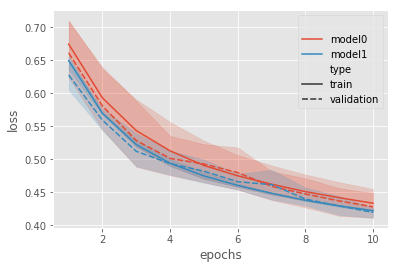

In [25]:
plt.style.use('ggplot')
ax = sns.lineplot(x="epochs", y="loss", style="type", hue= 'model', data=full_model_history_df)
legend = ax.legend()
legend.texts[0].set_text("")
plt.show()


In [ ]:
nr_of_images = 10
fig, ax = plt.subplots(nr_of_images,4, figsize=(8,20))
fig.tight_layout()
for image_nr in range(nr_of_images):
    ax[image_nr,0].imshow(X_train[image_nr].reshape(32,32))
    ax[image_nr,1].imshow(y_train[image_nr].reshape(32,32))
    y_pred = res.predict(X_train[image_nr:(image_nr+1)]).reshape(32,32)
    y_pred_thr = y_pred.copy()
    y_pred_thr[y_pred > 0.5] = 1
    y_pred_thr[y_pred <= 0.5] = 0
    ax[image_nr,2].imshow(y_pred)
    ax[image_nr,3].imshow(y_pred_thr)
    for j in range(4):
        ax[image_nr,j].set_xticklabels([])
        ax[image_nr,j].set_yticklabels([])
plt.show()



In [ ]:
def segment_image(image, mask, model, m, dataset):
    image = rgb2gray(image)
    patches, indexes = helpers.image_to_non_overlapping_patches(image, mask, m, helpers.Dataset.DRIVE)
    patches = np.array(patches)
    patches = patches.reshape(patches.shape[0], m, m, 1)
    y_pred = model.predict(patches).reshape(patches.shape[0], 32,32)
    y_pred_thr = y_pred.copy()
    y_pred_thr[y_pred > 0.5] = 1
    y_pred_thr[y_pred <= 0.5] = 0
    image = helpers.patches_to_image(y_pred_thr, indexes, m, image.shape[0], image.shape[1] )
    return image

In [ ]:
drive_images = helpers.load_images_from_folder(helpers.DRIVE_TEST_IMAGES_PATH)
drive_mask = helpers.load_images_from_folder(helpers.DRIVE_TEST_MASK_PATH)
drive_segmented = helpers.load_images_from_folder(helpers.DRIVE_TEST_SEG_1_PATH)

In [ ]:
image_segmentation = segment_image(drive_images[0], drive_mask[0], res, 32, helpers.Dataset.DRIVE)
fig, ax = plt.subplots(1,3, figsize=(20,20))
ax[0].imshow(image_segmentation)
ax[1].imshow(drive_segmented[0])
ax[2].imshow(helpers.histogram_equalization(drive_images[0]))

plt.show()